In [1]:
###Package Imports
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Predicting the Outcome of a League of Legends Game Based on What Happened in the First 10 Minutes

League of Legends is 5 vs 5 strategy game where two teams of players, piloting different champions, battle to destroy each other's base. The battle takes place on Summoner's Rift, the signature map for League of Legends (see picture below). The map features 3 lanes for champions to battle and a jungle region, where players can combat various monsters. Each team of 5 players is typically split into 5 roles: top, mid, bottom, jungle, and support. The top, mid, and bottom players each occupy one of the primiarily lanes on the map, except for the bottom lane where they are joined by the support. The jungle players spend their time within the jungle region battling monsters but occasionally make their way to a lane to participate in battle.The way to win is to destroy the opposing team's nexus, which is located at the center of each base, guarded by turrets nearby and across the lanes. Champions will battle to attack and defend their turrets and bases. They will collect gold through combat to forge powerful items and gain experience to level up and unlock new and more powerful abilities, to ultimately become victorious in battle. Champions can score kills on one another, but those fallen in battle will respawn after some time as long as the team's nexus is alive. However, the respawn time increases as the game progresses, and any death in the later stages renders a champion unable to defend their base for a long time. 

In theory, the first 10 minutes of the game for a League of Legends are very critical for the outcome of the game. Within the first 10 minutes, champions have yet unlock their most powerful skills or have access to many powerful items to siege their opponent's base. As such, the objective within this period is to accumlate resources and control objectives around the map. Compared to later in the game where any champion kill can be game winning due to long respawn time, an early game kill or death is not significant in isolation; However, since both team starts off even in terms of gold and level, any small advantage generated through skirmishes or objective captures can easily snowball into a game winning lead. By observing what occurs in the first 10 minutes, one can make a fair assessment to the potential outcome of the game. 

<img src="Map.png" alt="Drawing" style="width: 600px;"/>


**Glossary of game terminology**  <br>
- Team colors: the team starting from the southwest of the map is team blue; the team starting from the northeast is team red
- Gold: the in game currency used to purchase items, which powers up a champion's attributes
- Experience: determines the level of champions. Leveling up unlocks upgraded abilities and access to a champion's ultimate ability 
- Ward: a placeable item that grants vision to nearby area of placement 
- Minions: units that spawn regularly from each team's nexus and marches towards the opposing nexus through three different lanes. Grants experience and gold to player that kills it
- Jungle Monsters: units that spawn within the jungle region around the map. Grants experience and gold to players that kills it
- Elite Jungle Monsters: two large jungle monsters, named blue and red buff, within each team's jungle. Spawns at 1 minute and 30 seconds and respawns 5 minutes after it is killed. Grants experience, gold, and a special power to the player that kills i
- Dragons: dragon monster that spawns in the South river at 5 minutes and respawns 5 minutes after it is killed. When killed, grants players gold and experience, and a permenant team powerup
- Herald: a mutated crab monster that spawns in the North river at 8 minutes. Grants experience, gold, and a summon token when killed. The summon token can be deployed once to summon a herald, which will attack the nearest tower
- Creep Score (CS): represents the amount of minions and monsters a player killed

**The Data** <br>
The dataset is a collection of nearly 10,000 diamond or higher rank games and contains 19 different statistics for each team (38 total) about what occured in the first ten minutes of the game. The diamond rank and higher represents the the top 1.5 percentile of all league of legends player in terms of skill. Players on both teams are relatively even in terms of skill and the outcome of the game is far more predictable due to the level of mastery of the players. 

**Brief Overview of Variables:** <br>
- gameId: the ID of the game within the Riot Games API where game data is fetched <br>
- blueWins: the outcome variable representing if the blue team is victorious

Shared Variables Between Both Teams: <br>
- WardsPlaced: the amount of wards placed <br>
- WardsDestroyed: the amount of wards destroyed <br>
- FirstBlood: if the team scored the first kill of the game, granting 100 extra gold <br>
- Kills: total kills on opposing champions <br>
- Deaths: total deaths due to opposing champions <br>
- Assists: all participants in combat besides the one scoring the kill receives an assist <br>
- EliteMonsters: the amount of elite monsters killed by a team <br>
- Dragons: the amount of dragons killed by a team <br>
- Heralds: the amount of rift hearld killed by a team <br>
- TowersDestroyed: the amount of tower destroyed by a team <br>
- TotalGold: the cumlative amount of gold of all players on a team <br>
- AvgLevel: the average level of champions on a team <br>
- TotalExperience: the cumlative experience of all players on a team <br>
- TotalMinionsKilled: the total amount of minions killed of all players on a team <br>
- TotalJungleMinionsKilled: the total amount of jungle monsters killed by all playerson a team <br>
- GoldDiff: the difference in gold across the two teams <br>
- ExperienceDiff: the difference in experience 
- CSPerMin: creep scores per minute <br>
- GoldPerMin: the gold accumlated per minute as a team  <br>

### Reading in the data

In [2]:
df = pd.read_csv('https://github.com/kevinz6/league-of-legends-game-prediction/blob/main/high_diamond_ranked_10min.csv?raw=true')
df.head()

gameId  blueWins  blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  \
0  4519157822         0               28                   2               1   
1  4523371949         0               12                   1               0   
2  4521474530         0               15                   0               0   
3  4524384067         0               43                   1               0   
4  4436033771         0               75                   4               0   

   blueKills  blueDeaths  blueAssists  blueEliteMonsters  blueDragons  ...  \
0          9           6           11                  0            0  ...   
1          5           5            5                  0            0  ...   
2          7          11            4                  1            1  ...   
3          4           5            5                  1            0  ...   
4          6           6            6                  0            0  ...   

   redTowersDestroyed  redTotalGold  redAvgLevel  redTotalExperience  \
0                   0         16567          6.8               17047   
1                   1         17620          6.8               17438   
2                   0         17285          6.8               17254   
3                   0         16478          7.0               17961   
4                   0         17404          7.0               18313   

   redTotalMinionsKilled  redTotalJungleMinionsKilled  redGoldDiff  \
0                    197                           55         -643   
1                    240                           52         2908   
2                    203                           28         1172   
3                    235                           47         1321   
4                    225                           67         1004   

   redExperienceDiff  redCSPerMin  redGoldPerMin  
0                  8         19.7         1656.7  
1               1173         24.0         1762.0  
2               1033         20.3         1728.5  
3                  7         23.5         1647.8  
4               -230         22.5         1740.4  

[5 rows x 40 columns]

In [3]:
df.shape

(9879, 40)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

There are no missing values in the dataset.

In [5]:
df.describe()

gameId     blueWins  blueWardsPlaced  blueWardsDestroyed  \
count  9.879000e+03  9879.000000      9879.000000         9879.000000   
mean   4.500084e+09     0.499038        22.288288            2.824881   
std    2.757328e+07     0.500024        18.019177            2.174998   
min    4.295358e+09     0.000000         5.000000            0.000000   
25%    4.483301e+09     0.000000        14.000000            1.000000   
50%    4.510920e+09     0.000000        16.000000            3.000000   
75%    4.521733e+09     1.000000        20.000000            4.000000   
max    4.527991e+09     1.000000       250.000000           27.000000   

       blueFirstBlood    blueKills   blueDeaths  blueAssists  \
count     9879.000000  9879.000000  9879.000000  9879.000000   
mean         0.504808     6.183925     6.137666     6.645106   
std          0.500002     3.011028     2.933818     4.064520   
min          0.000000     0.000000     0.000000     0.000000   
25%          0.000000     4.000000     4.000000     4.000000   
50%          1.000000     6.000000     6.000000     6.000000   
75%          1.000000     8.000000     8.000000     9.000000   
max          1.000000    22.000000    22.000000    29.000000   

       blueEliteMonsters  blueDragons  ...  redTowersDestroyed  redTotalGold  \
count        9879.000000  9879.000000  ...         9879.000000   9879.000000   
mean            0.549954     0.361980  ...            0.043021  16489.041401   
std             0.625527     0.480597  ...            0.216900   1490.888406   
min             0.000000     0.000000  ...            0.000000  11212.000000   
25%             0.000000     0.000000  ...            0.000000  15427.500000   
50%             0.000000     0.000000  ...            0.000000  16378.000000   
75%             1.000000     1.000000  ...            0.000000  17418.500000   
max             2.000000     1.000000  ...            2.000000  22732.000000   

       redAvgLevel  redTotalExperience  redTotalMinionsKilled  \
count  9879.000000         9879.000000            9879.000000   
mean      6.925316        17961.730438             217.349226   
std       0.305311         1198.583912              21.911668   
min       4.800000        10465.000000             107.000000   
25%       6.800000        17209.500000             203.000000   
50%       7.000000        17974.000000             218.000000   
75%       7.200000        18764.500000             233.000000   
max       8.200000        22269.000000             289.000000   

       redTotalJungleMinionsKilled   redGoldDiff  redExperienceDiff  \
count                  9879.000000   9879.000000        9879.000000   
mean                     51.313088    -14.414111          33.620306   
std                      10.027885   2453.349179        1920.370438   
min                       4.000000 -11467.000000       -8348.000000   
25%                      44.000000  -1596.000000       -1212.000000   
50%                      51.000000    -14.000000          28.000000   
75%                      57.000000   1585.500000        1290.500000   
max                      92.000000  10830.000000        9333.000000   

       redCSPerMin  redGoldPerMin  
count  9879.000000    9879.000000  
mean     21.734923    1648.904140  
std       2.191167     149.088841  
min      10.700000    1121.200000  
25%      20.300000    1542.750000  
50%      21.800000    1637.800000  
75%      23.300000    1741.850000  
max      28.900000    2273.200000  

[8 rows x 40 columns]

### Cleaning Up the Data

The gameId column is not one of the feature variables for prediction so it should be dropped

In [6]:
df.drop(columns = 'gameId', inplace = True)

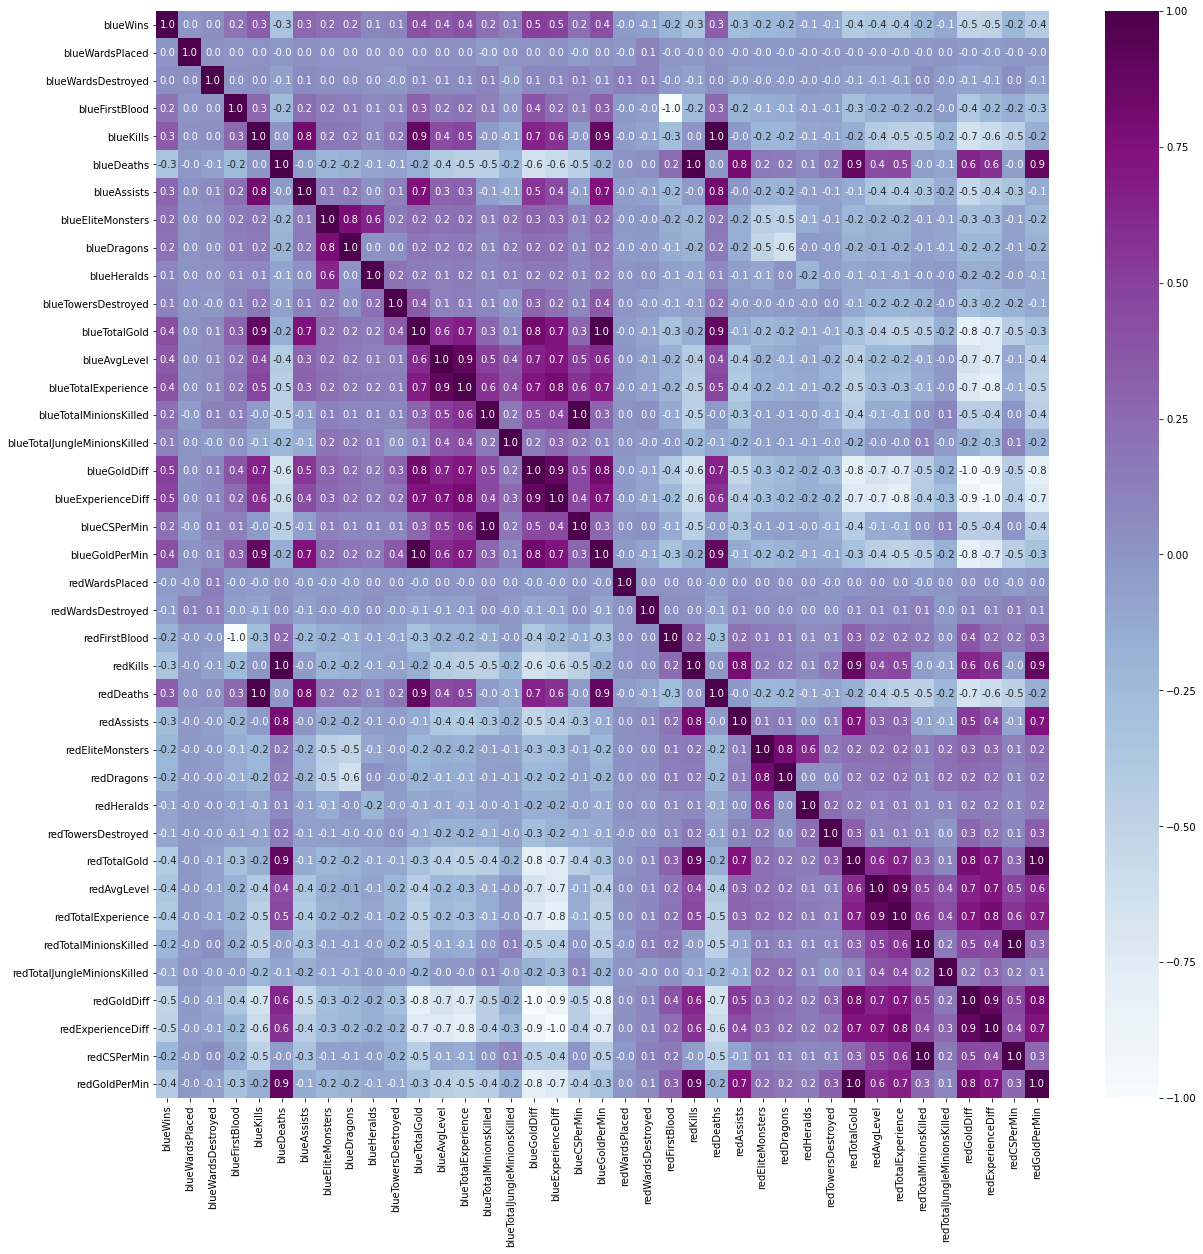

In [7]:
f, ax = plt.subplots(figsize = (20, 20))
ax = sns.heatmap(df.corr(), cmap = 'BuPu', annot = True, fmt = '.1f')
plt.show()

The remaining data contains 1 outcome variable, 'blueWins' and 38 feature variables, which is a large amount of variables. The heatmap shows that many variables in the data are highly correlated with one another, so there is a high likelihood of overfitting when a model is used. As such, the dimensionality of the data should be reduced.

To start, there are many variables in the dataset that are related since they are the same information recorded for both teams. For example, the variable 'blueKills' is the same as 'redDeaths' since every kill the blue team gets results in a death on the red team. Similiarily, 'blueFirstBlood' and 'redFirstBlood' are inverses of each other since only one team can get first blood in each game. 

Additionally, there are also variables that are stored both for total and per minute like 'blueTotalGold' and 'blueGoldPerMin' etc.

Here is the list of related variables and only one in each pair should be kept in the data: <br>
- blueFirstBlood ~ redFirstBlood 
- blueKills ~ redDeaths 
- blueDeaths ~ redKills 
- blueGoldDiff ~ redGoldDiff 
- blueExperienceDiff ~ redExperienceDiff 
- blueTotalGold ~ blueGoldPerMin 
- blueTotalMinionsKilled ~ blueCSPerMin 
- redTotalGold ~ redGoldPerMin 
- redTotalMinionsKilled ~ redCSPerMin 

In [8]:
df.drop(columns = ['redFirstBlood', 'redDeaths', 'redKills', 'redGoldDiff', 'redExperienceDiff', 'blueGoldPerMin', 'blueCSPerMin', 'redGoldPerMin', 'redCSPerMin'], inplace = True)

Finally, instead of recording two separate variables to represent each team's performance on minion, monster, dragon, and herald kills, one variable can be used to represent the difference between the teams on these categories. This is also relevant  for model building since knowning how much blue team is doing better/worse on a certain category is more useful for predicting a victor than the standalone numbers for each team.

As such, the following variables are combined:
- TotalMinionsKilled
- TotalJungleMinionsKilled
- EliteMonsters
- Dragons
- Heralds
- Towers
- Total Gold
- Total Experience
- Avg Level

A positive value in these variables indicates that blue team has the advantage.

In [9]:
df.columns

Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
       'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'redWardsPlaced', 'redWardsDestroyed', 'redAssists', 'redEliteMonsters',
       'redDragons', 'redHeralds', 'redTowersDestroyed', 'redTotalGold',
       'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled',
       'redTotalJungleMinionsKilled'],
      dtype='object')

In [10]:
df['TotalMinionsDiff'] = df['blueTotalMinionsKilled'] - df['redTotalMinionsKilled']
df['JungleDiff'] = df['blueTotalJungleMinionsKilled'] - df['redTotalJungleMinionsKilled']
df['EliteMonsterDiff'] = df['blueEliteMonsters'] - df['redEliteMonsters']
df['DragonDiff'] = df['blueDragons'] - df['redDragons']
df['HeraldsDiff'] = df['blueHeralds'] - df['redHeralds']
df['TowersDiff'] = df['blueTowersDestroyed'] - df['redTowersDestroyed']
df['AvgLevelDiff'] = df['blueAvgLevel'] - df['redAvgLevel']
df.drop(columns = ['blueTotalMinionsKilled', 'redTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'redTotalJungleMinionsKilled','blueEliteMonsters', 'redEliteMonsters',
                   'blueDragons', 'redDragons', 'blueHeralds','redHeralds', 'blueTowersDestroyed','redTowersDestroyed', 'blueAvgLevel','redAvgLevel',
                  'blueTotalExperience', 'redTotalExperience', 'blueTotalGold', 'redTotalGold'], inplace = True)

In [11]:
df.rename(columns = {'blueGoldDiff': 'GoldDiff', 'blueExperienceDiff': 'ExpDiff'}, inplace = True)
df.columns

Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'GoldDiff', 'ExpDiff',
       'redWardsPlaced', 'redWardsDestroyed', 'redAssists', 'TotalMinionsDiff',
       'JungleDiff', 'EliteMonsterDiff', 'DragonDiff', 'HeraldsDiff',
       'TowersDiff', 'AvgLevelDiff'],
      dtype='object')

### Exploratory Data Analysis

In [12]:
df_win_count = df.groupby('blueWins').size()
fig = px.bar(data_frame = df_win_count, title = 'Distribution Game Outcomes',
            labels = {'blueWins':'Outcome', 'value': 'Count'})
fig.show()

Based on the boxplot, there are roughly equal amounts of wins and losses for the blue team in the dataset. There is no extreme bias or skewness that suggests if one team is favored. Both red and blue appears to have equal chances on winning.

**Analysis of wards placed and its relation to the outcome**

In [13]:
df_ward_placed = df[['blueWins', 'blueWardsPlaced', 'redWardsPlaced']].copy()
fig = px.box(data_frame = df_ward_placed, 
       x = ['blueWardsPlaced', 'redWardsPlaced'], 
       orientation = 'h',
       labels = {'variable':'Teams', 'value': 'Amount of Wards Placed'},
       title = 'Boxplot of Wards Placed by Both Blue and Red Team')
fig.show()

The distribution of the amount of wards placed for both teams are heavily skewed to the right. There are many extreme values above the 200s for wards placed. While these values are possible, under normal game play circumstances, it is unlikely to see this many wards placed since wards are on a 180 second deployment cool down for every player except those in the support role. This variable should be cautiously used for the model.

In [14]:
fig1 = px.box(data_frame = df_ward_placed, 
       x ='blueWardsPlaced', 
       y = 'blueWins', 
       orientation = 'h', 
       labels = {'variable':'Outcome of Game', 'value': 'Amount of Wards Placed'},
       title = 'Boxplot of Wards Placed from Blue Team by the Outcome of the Game')
fig2 = px.box(data_frame = df_ward_placed, 
       x ='redWardsPlaced', 
       y = 'blueWins', 
       orientation = 'h', 
       labels = {'variable':'Outcome of Game', 'value': 'Amount of Wards Placed'},
       title = 'Boxplot of Wards Placed from Red Team by the Outcome of the Game')
fig1.show()
fig2.show()

Based on the pair of boxplots above, it seems like the distribution of wards placed by both blue and red team are about the same for games blue won and loss. 

**Analysis of the Effect of Gold and Experience Advantage to the Outcome**

In [15]:
fig = px.box(data_frame = df,
            x = 'GoldDiff',
            y = 'blueWins',
            orientation = 'h', 
           labels = {'variable':'Outcome of Game', 'value': 'The difference in gold'},
           title = 'The Gold Advantage for Blue Team by the Outcome of the Game')
fig.show()

fig2 = px.box(data_frame = df,
            x = 'ExpDiff',
            y = 'blueWins',
            orientation = 'h', 
           labels = {'variable':'Outcome of Game', 'value': 'The difference in experience'},
           title = 'The Experience Advantage for Blue Team by the Outcome of the Game')
fig2.show()



Based on this pair of boxplots, the distribution for both gold and experience are different based on the outcome of the game. The median gold and experience different is positive when team blue wins and negative when blue loses. An advantage in terms of gold and experience in the first 10 minutes of game play likely builds to a bigger advantage in the later stages of the game, which ultimately yields a victory.

**Analysis of the Effect of Capturing Dragon and Herald to the Outcome** <br>
The following visuals are created in tableau:

<img src="visuals/dragon.png" alt="Drawing" style="width: 800px;"/>
<img src="visuals/herald.png" alt="Drawing" style="width: 600px;"/>

Both bar charts are split into three categories for the three possible outcomes to capturing the dragon/herald: team red, no team, or team blue. For both dragon and herald, a team that captures one has a higher likelihood of winning. The dragon is defeated more often within the first 10 minutes, whereas the herald is not taken for around $\frac{2}{3}$ of the games. As expected, when neither objective is captured during the first 10 minutes, the outcome of the game is evenly split. A team getting a dragon or herald early is a good predicator for a team's success but not getting one does not reveal any additional information about the outcome.  

### Model Building

Before building the model, the data should be divided into feature and response variables and then split into training and testing sets to validate the model.

In [16]:
y = df['blueWins']
X = df.drop(columns = 'blueWins').copy()
X.columns

Index(['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills',
       'blueDeaths', 'blueAssists', 'GoldDiff', 'ExpDiff', 'redWardsPlaced',
       'redWardsDestroyed', 'redAssists', 'TotalMinionsDiff', 'JungleDiff',
       'EliteMonsterDiff', 'DragonDiff', 'HeraldsDiff', 'TowersDiff',
       'AvgLevelDiff'],
      dtype='object')

The data will be split into 60% training and 40% testing. The stratify parameter ensures that both training and testing data gets an equal ratio of outcomes of the response variable 

In [17]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.4, stratify = y)
train_y.value_counts(), test_y.value_counts()

(0    2969
 1    2958
 Name: blueWins, dtype: int64,
 0    1980
 1    1972
 Name: blueWins, dtype: int64)

**Logistic Regression #1**

The first model is a simple logistic regression. This will serve as the baseline to evaluate the performances of other models.

In [18]:
log_reg = LogisticRegression(solver = 'liblinear', fit_intercept = True)
log_reg.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [19]:
coef = np.hstack(log_reg.coef_)
print(f'Intercept: {log_reg.intercept_}')
print(pd.DataFrame({'Predictor': train_X.columns,'coefficient': coef}))

Intercept: [-0.00040339]
             Predictor  coefficient
0      blueWardsPlaced    -0.002012
1   blueWardsDestroyed     0.013292
2       blueFirstBlood     0.031275
3            blueKills     0.008458
4           blueDeaths     0.009064
5          blueAssists    -0.021229
6             GoldDiff     0.000475
7              ExpDiff     0.000230
8       redWardsPlaced    -0.000058
9    redWardsDestroyed    -0.011804
10          redAssists     0.011021
11    TotalMinionsDiff    -0.003564
12          JungleDiff     0.000455
13    EliteMonsterDiff     0.132211
14          DragonDiff     0.188343
15         HeraldsDiff    -0.056133
16          TowersDiff    -0.038488
17        AvgLevelDiff     0.000388


In [20]:
y_pred = log_reg.predict(test_X)
tn, fp, fn, tp = confusion_matrix(y_true = test_y, y_pred = y_pred).ravel()
print('Accuracy', accuracy_score(y_true = test_y, y_pred = y_pred))
print(pd.DataFrame(confusion_matrix(y_true = test_y, y_pred = y_pred)))
print('Sensitivity:', tp / (tp + fn))
print('Specificity:', tn / (tn + fp))

Accuracy 0.7259615384615384
      0     1
0  1441   539
1   544  1428
Sensitivity: 0.7241379310344828
Specificity: 0.7277777777777777


In [21]:
scores = cross_val_score(log_reg, test_X, test_y, cv= 10)
print('Mean Accuracy for 10-fold Cross Validation:', scores.mean())

Mean Accuracy for 10-fold Cross Validation: 0.7239432297660147


A 10-fold cross validation shows that the simple logistic regression model achieves an accuracy of 0.7239.

**Logistic Regression #2**

The next models is a reduced logistic regression model. Variables are removed based off discoveries in the EDA.

To start, the distribution of wards placed are relatively similar for both outcomes of the game so the ward related variables will be removed to see if performance improves.

In [22]:
train_X_reduced = train_X.drop(columns = ['blueWardsPlaced', 'redWardsPlaced', 'blueWardsDestroyed', 'redWardsDestroyed'])
test_X_reduced = test_X.drop(columns = ['blueWardsPlaced', 'redWardsPlaced', 'blueWardsDestroyed', 'redWardsDestroyed'])

In [23]:
log_reg_2 = LogisticRegression(solver = 'liblinear', fit_intercept = True)
log_reg_2.fit(train_X_reduced, train_y)
y_pred = log_reg_2.predict(test_X_reduced)
tn, fp, fn, tp = confusion_matrix(y_true = test_y, y_pred = y_pred).ravel()
print('Accuracy', accuracy_score(y_true = test_y, y_pred = y_pred))
print(pd.DataFrame(confusion_matrix(y_true = test_y, y_pred = y_pred)))
print('Sensitivity:', tp / (tp + fn))
print('Specificity:', tn / (tn + fp))

Accuracy 0.7267206477732794
      0     1
0  1441   539
1   541  1431
Sensitivity: 0.7256592292089249
Specificity: 0.7277777777777777


In [24]:
log_reg_cv = LogisticRegressionCV(solver = 'liblinear', cv = 10).fit(train_X_reduced, train_y)
score = log_reg_cv.score(test_X_reduced, test_y)
print('Mean Accuracy for 10-fold Cross Validation:', score.mean())

Mean Accuracy for 10-fold Cross Validation: 0.7264676113360324


The performance improved but not by a significant amount. The 10-fold cross validation shows an accuracy score of 0.7265.

**Logistic Regression #3**

Since there are 18 predictors, it is very likely the model overfits. Using PCA can reduce the dimension of the data.

In [25]:
scaler = StandardScaler()
scaler.fit(train_X) 

train_pca = scaler.transform(train_X)
test_pca = scaler.transform(test_X)

In [26]:
pca = PCA(0.90)
pca.fit(train_pca)
print(pca.n_components_)
train_pca = pca.transform(train_pca)
test_pca = pca.transform(test_pca)

log_reg_3 = LogisticRegression(solver = 'liblinear', fit_intercept = True)
log_reg_3.fit(train_pca, train_y)
y_pred = log_reg_3.predict(test_pca)
tn, fp, fn, tp = confusion_matrix(y_true = test_y, y_pred = y_pred).ravel()
print('Accuracy', accuracy_score(y_true = test_y, y_pred = y_pred))
print(pd.DataFrame(confusion_matrix(y_true = test_y, y_pred = y_pred)))
print('Sensitivity:', tp / (tp + fn))
print('Specificity:', tn / (tn + fp))

11
Accuracy 0.7165991902834008
      0     1
0  1408   572
1   548  1424
Sensitivity: 0.7221095334685599
Specificity: 0.7111111111111111


In [27]:
log_reg_cv = LogisticRegressionCV(solver = 'liblinear', cv = 10).fit(train_pca, train_y)
score = log_reg_cv.score(test_pca, test_y)
print('Mean Accuracy for 10-fold Cross Validation:', score)

Mean Accuracy for 10-fold Cross Validation: 0.7193825910931174


PCA did not improve the accuracy of the regression. The 10-fold CV shows an accuracy score of 0.7194.

**Tree-based Models**

Tree based models will be tested to see if higher accuracy can be achieved. 

In [28]:
tree = DecisionTreeClassifier(max_depth = 5)
tree.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=5)

In [29]:
y_pred = tree.predict(test_X)
tn, fp, fn, tp = confusion_matrix(y_true = test_y, y_pred = y_pred).ravel()
print('Accuracy', accuracy_score(y_true = test_y, y_pred = y_pred))
print(pd.DataFrame(confusion_matrix(y_true = test_y, y_pred = y_pred)))
print('Sensitivity:', tp / (tp + fn))
print('Specificity:', tn / (tn + fp))

Accuracy 0.7009109311740891
      0     1
0  1353   627
1   555  1417
Sensitivity: 0.7185598377281948
Specificity: 0.6833333333333333


In [30]:
scores = cross_val_score(tree, test_X, test_y, cv= 10)
print('Mean Accuracy for 10-fold Cross Validation:', scores.mean())

Mean Accuracy for 10-fold Cross Validation: 0.6988965605421302


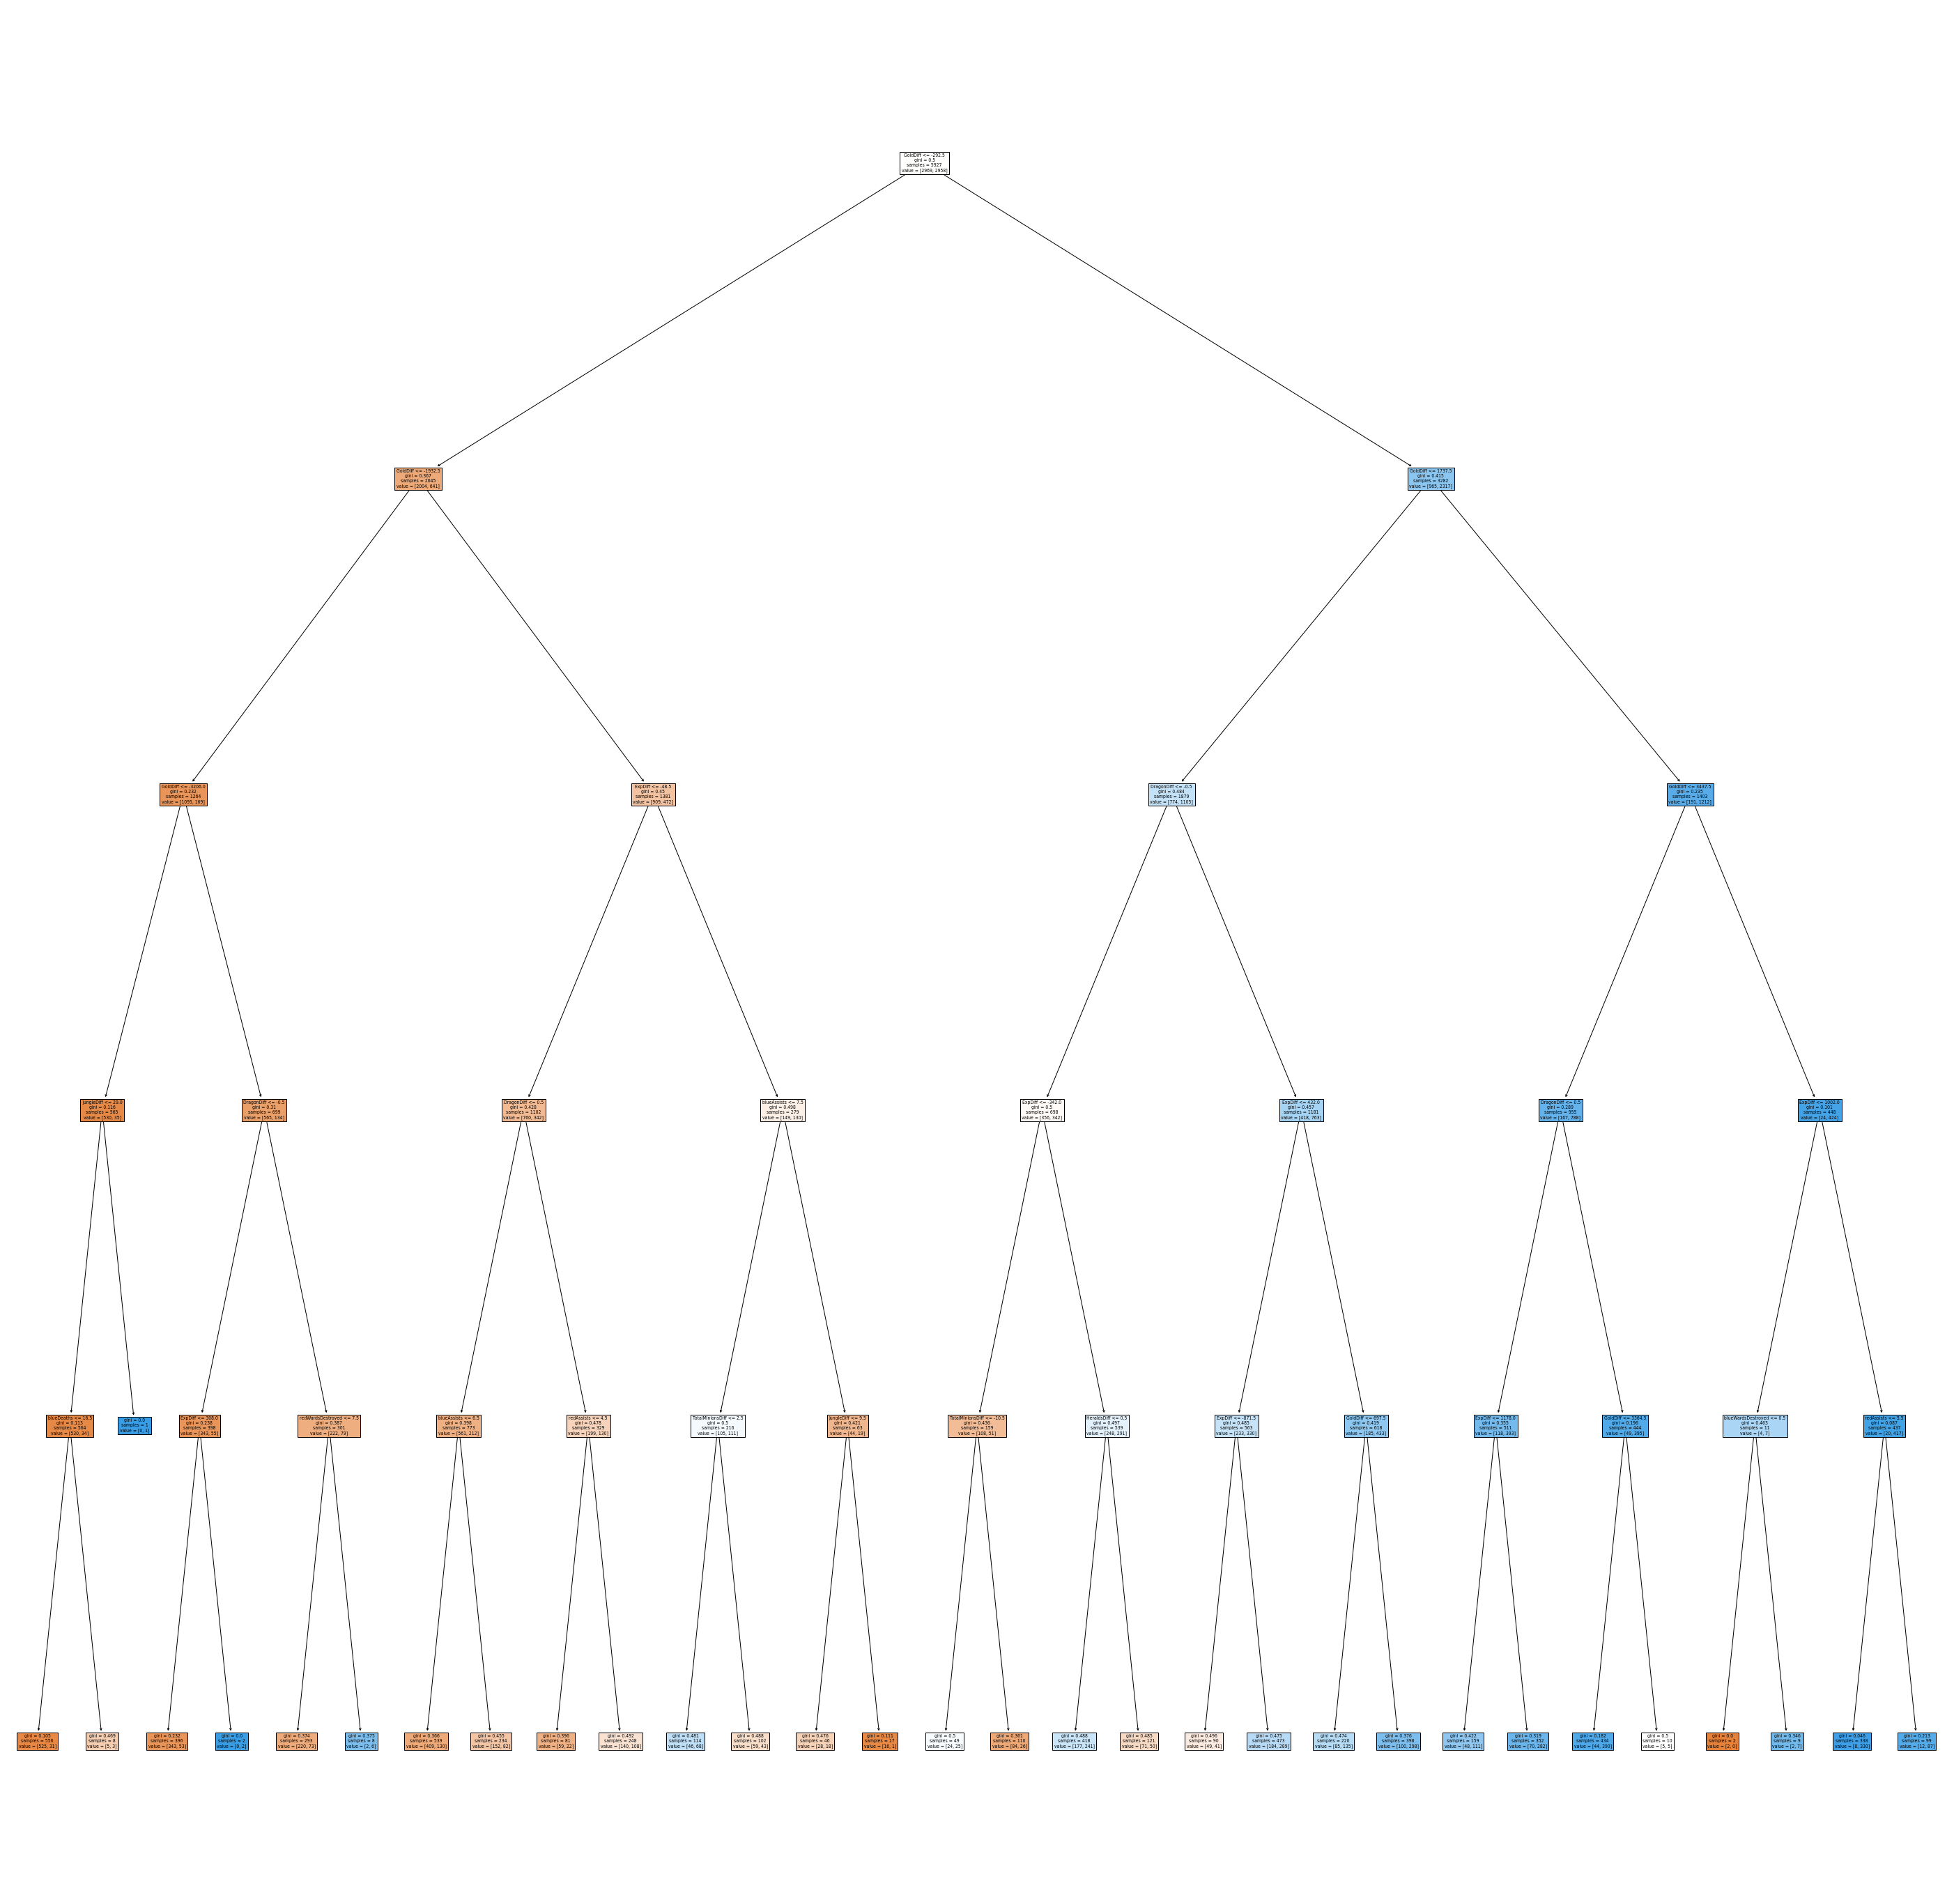

In [31]:
fig = plt.figure(figsize = (50, 50))
plot_tree(tree, feature_names = test_X.columns, filled = True)
plt.show()

The tree will also be fitted on the reduced training data (without data relating to wards)

In [32]:
tree2 = DecisionTreeClassifier(max_depth = 5)
tree2.fit(train_X_reduced, train_y)
y_pred = tree2.predict(test_X_reduced)
tn, fp, fn, tp = confusion_matrix(y_true = test_y, y_pred = y_pred).ravel()
print('Accuracy', accuracy_score(y_true = test_y, y_pred = y_pred))
print(pd.DataFrame(confusion_matrix(y_true = test_y, y_pred = y_pred)))
print('Sensitivity:', tp / (tp + fn))
print('Specificity:', tn / (tn + fp))

Accuracy 0.6993927125506073
      0     1
0  1354   626
1   562  1410
Sensitivity: 0.7150101419878296
Specificity: 0.6838383838383838


In [33]:
scores = cross_val_score(tree2, test_X_reduced, test_y, cv= 10)
print('Mean Accuracy for 10-fold Cross Validation:', scores.mean())

Mean Accuracy for 10-fold Cross Validation: 0.7016775348420918


The reduced tree model performed slightly better than the full tree model. However the simple decision trees did not achieve a better accuracy than the logistic regression model.

**Random Forest Model**

Finally, a random forest model, which is an accumlation of many decision trees, will be tested.

In [34]:
rftree = RandomForestClassifier(n_estimators = 100, max_depth = 5)
rftree.fit(train_X, train_y)

RandomForestClassifier(max_depth=5)

In [35]:
y_pred = rftree.predict(test_X)
tn, fp, fn, tp = confusion_matrix(y_true = test_y, y_pred = y_pred).ravel()
print('Accuracy', accuracy_score(y_true = test_y, y_pred = y_pred))
print(pd.DataFrame(confusion_matrix(y_true = test_y, y_pred = y_pred)))
print('Sensitivity:', tp / (tp + fn))
print('Specificity:', tn / (tn + fp))

Accuracy 0.72165991902834
      0     1
0  1430   550
1   550  1422
Sensitivity: 0.7210953346855984
Specificity: 0.7222222222222222


In [37]:
scores = cross_val_score(rftree, test_X_reduced, test_y, cv= 10)
print('Mean Accuracy for 10-fold Cross Validation:', scores.mean())

Mean Accuracy for 10-fold Cross Validation: 0.7173615905894387


The random forest model performed better than the simple decision tree but worse than the logistic regressions.

### Conclusion

Overall, by a narrow margin, the logistic regression model with wards variable removed performed the best in terms of accuracy of 72.65%. All of the other models shared a similar level of performance in accuracy at around 71%. Just using data from the first 10 minutes of a league of legends game, models are able to correctly predict a majority of the outcome game. With further refinement, the models may perform even better but there are also limitations. 
Due to the nature of video games, unexpected events can occur later in the game that turns the tide of the game and negate advantages built in earlier stages. Additionally, individual players' skills, despite being at highly competitive level, are not neccessarily even across the team. The models cannot account for many of these factors, which cause it to fall short for some predictions. The unpredictability of the outcome, however, is exciting for the players and spectators, as at any moment, the potential outcome of the game can change. 